# Seasonal amplitude

Examine aircraft observations relative to deseasonalized record at South Pole Observatory (SPO). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import xarray as xr
xr.set_options(display_style='text')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datasets
import emergent_constraint as ec
import figure_panels
import obs_aircraft
import obs_surface
import regression_models
import util

## Compute trends at SPO 

Apply the [Seasonal-Trend decomposition using LOESS (STL)](https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
) decomposition.

Load the observations and "simulated" observations.

In [3]:
da_srf = obs_surface.open_surface_co2_data('obs', 'CO2')
da_srf = da_srf.sel(record='SPO_NOAA_insitu_CO2')
da_srf

<xarray.DataArray 'CO2' (time: 255)>
array([365.087     , 365.0233    , 364.9477    , 364.8559    ,
       365.0247    , 365.2323    , 365.5536    , 365.8787    ,
       366.267     , 366.5252    , 366.6619    , 366.769     ,
       366.6823    , 366.5256    , 366.3785    , 366.2866    ,
       366.3605    , 366.4866    , 366.7825    , 367.2251    ,
       367.7117    , 367.916     , 367.9165    , 367.8272    ,
       368.082     , 367.90657444, 367.73680778, 367.5727    ,
       367.8431    , 368.103     , 368.361     , 368.7956    ,
       369.2895    , 369.62      , 369.8711    , 369.9044    ,
       369.7054    , 369.5646    , 369.4809    , 369.5215    ,
       369.7851    , 370.0466    , 370.4399    , 370.942     ,
       371.4619    , 371.9008    , 372.0636    , 372.0244    ,
       371.9033    , 371.9839    , 371.8845    , 371.9864    ,
       372.1395    , 372.4602    , 372.8071    , 373.2333    ,
       373.8026    , 374.1147    , 374.1257    , 374.017     ,
       374.0089    , 374.0475    , 373.8567    , 374.0551    ,
       374.1877    , 374.3905    , 374.7571    , 375.0748    ,
       375.58      , 375.7441    , 375.7188    , 375.6784    ,
       375.6514    , 375.6136    , 375.2336    , 375.435     ,
       375.62      , 376.0597    , 376.5817    , 377.0944    ,
...
       393.7438    , 394.0009    , 394.0185    , 393.9805    ,
       393.9337    , 393.8893    , 393.64      , 393.6919    ,
       393.8313    , 394.2192    , 394.5398    , 395.0099    ,
       395.5185    , 395.87      , 395.9552    , 395.9001    ,
       395.7913    , 395.7926    , 395.7917    , 395.8432    ,
       396.1575    , 396.6362    , 397.0309    , 397.4532    ,
       398.0054    , 398.3961    , 398.356     , 398.5408    ,
       398.5384    , 398.679     , 398.5409    , 399.0028    ,
       399.327     , 399.9535    , 400.5186    , 401.0858    ,
       401.4933    , 401.6599    , 401.7256    , 401.5035    ,
       401.3839    , 401.2491    , 401.1308    , 401.0807    ,
       401.2104    , 401.6609    , 402.0518    , 402.6256    ,
       403.2118    , 403.5453    , 403.7024    , 403.6678    ,
       403.6577    , 403.8061    , 403.7602    , 403.7886    ,
       404.1269    , 404.4542    , 404.7167    , 405.1911    ,
       405.6863    , 406.0499    , 406.1676    , 406.1611    ,
       406.1531    , 405.8242    , 405.8083    , 405.8894    ,
       406.1281    , 406.642     , 407.1523    , 407.8425    ,
       408.3913    , 408.716     , 408.8633    , 408.907     ,
       408.8532    ,          nan,          nan])
Coordinates:
  * time         (time) datetime64[ns] 1998-12-15 1999-01-15 ... 2020-02-14
    year_frac    (time) float64 1.999e+03 1.999e+03 ... 2.02e+03 2.02e+03
    record       <U19 'SPO_NOAA_insitu_CO2'
    institution  object 'NOAA'
    lat          float64 -89.98
    lon          float64 -24.8
    stncode      object 'SPO'
Attributes:
    long_name:  CO$_2$
    units:      ppm

Apply the STL decomposition.

In [4]:
spo_fit = regression_models.apply_stl_decomp(da_srf)
spo_fit

STL fit: r^2 = 0.9995
STL fit: r^2 = 0.6460


<xarray.Dataset>
Dimensions:    (time: 253)
Coordinates:
  * time       (time) datetime64[ns] 1998-12-15 1999-01-15 ... 2019-12-15
Data variables:
    observed   (time) float64 365.1 365.0 364.9 364.9 ... 408.9 408.9 408.9
    trend      (time) float64 365.0 365.1 365.2 365.4 ... 408.2 408.5 408.7
    seasonal   (time) float64 0.2382 -0.03256 -0.2768 ... 0.5762 0.3978 0.141
    resid      (time) float64 -0.1452 -0.05815 -0.009257 ... 0.0387 0.01686
    predicted  (time) float64 365.2 365.1 365.0 364.8 ... 408.8 408.9 408.8
Attributes:
    r2:       0.9998202309704811

### Visualize the STL components

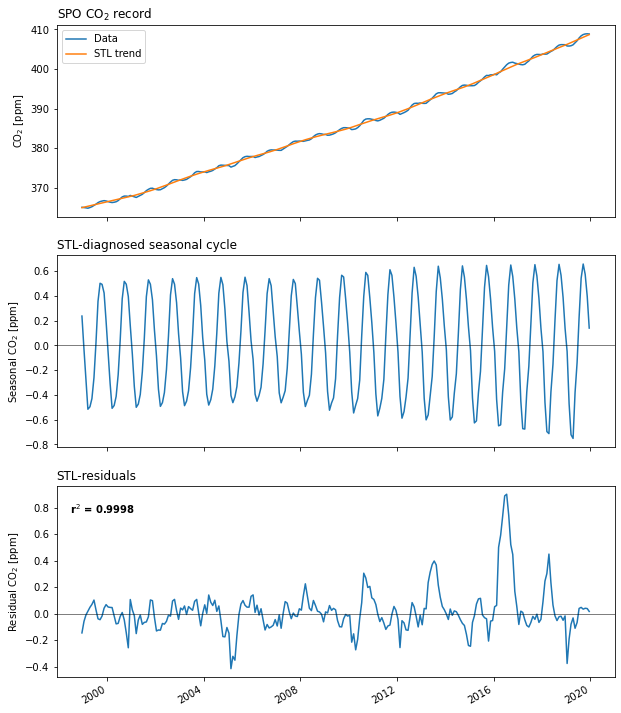

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12), squeeze=False,)

spo_fit.observed.plot(label='Data', ax=axs[0, 0])
spo_fit.trend.plot(label='STL trend', ax=axs[0, 0])
axs[0, 0].set_ylabel('CO$_2$ [ppm]')
axs[0, 0].set_xlabel('')
axs[0, 0].set_xticklabels([])
axs[0, 0].legend()
axs[0, 0].set_title('SPO CO$_2$ record', loc='left')

spo_fit.seasonal.plot(ax=axs[1, 0])
axs[1, 0].axhline(0, linewidth=0.5, color='k')
plt.title('Seasonal component of STL fit')
axs[1, 0].set_ylabel('Seasonal CO$_2$ [ppm]')
axs[1, 0].set_xlabel('')
axs[1, 0].set_xticklabels([])
axs[1, 0].set_title('STL-diagnosed seasonal cycle', loc='left')

spo_fit.resid.plot(ax=axs[2, 0])
axs[2, 0].axhline(0, linewidth=0.5, color='k')
axs[2, 0].set_ylabel('Residual CO$_2$ [ppm]')
axs[2, 0].set_xlabel('')
axs[2, 0].set_title('STL-residuals', loc='left')
ylm = np.array(axs[2, 0].get_ylim())
axs[2, 0].text(
    axs[2, 0].get_xlim()[0]+200, ylm[1]-np.diff(ylm)*0.15, 
    f'r$^2$ = {spo_fit.r2:0.4f}',
    fontweight='bold',
    ha='left',
);

## Aircraft profiles

In [6]:
dsets_prof = datasets.aircraft_profiles('obs')[['co2_med']]
dsets_prof

<xarray.Dataset>
Dimensions:    (profile: 361, theta: 27)
Coordinates:
    campaign   (profile) <U32 'HIPPO-1' 'HIPPO-1' ... 'ORCAS-F' 'ORCAS-F'
    doy        (profile) float64 20.0 20.0 20.0 20.0 20.0 ... 56.0 56.0 0.0 0.0
    flight_id  (profile) <U32 'HIPPO-001-007' ... 'ORCAS-001-019'
    lat        (profile) float64 -44.73 -46.5 -49.75 ... -54.85 -51.65 -45.44
    lon        (profile) float64 170.4 169.6 170.1 ... -68.29 -72.46 -76.02
    month      (profile) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0 2.0
  * profile    (profile) <U17 'HIPPO-001-007-074' ... 'ORCAS-001-019-207'
  * theta      (theta) float64 270.0 275.0 280.0 285.0 ... 390.0 395.0 400.0
    time       (profile) datetime64[ns] 2009-01-20 2009-01-20 ... 2016-02-29
    year       (profile) float64 2.009e+03 2.009e+03 ... 2.016e+03 2.016e+03
Data variables:
    co2_med    (profile, theta) float64 nan nan nan nan nan ... nan nan nan nan

In [7]:
spo_trend = xr.DataArray(
    np.interp(dsets_prof.time, spo_fit.time, spo_fit.trend),
    dims=('profile'), 
)
dco2 = dsets_prof.co2_med - spo_trend
dco2

<xarray.DataArray (profile: 361, theta: 27)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * profile    (profile) object 'HIPPO-001-007-074' ... 'ORCAS-001-019-207'
    campaign   (profile) <U32 'HIPPO-1' 'HIPPO-1' ... 'ORCAS-F' 'ORCAS-F'
    doy        (profile) float64 20.0 20.0 20.0 20.0 20.0 ... 56.0 56.0 0.0 0.0
    flight_id  (profile) <U32 'HIPPO-001-007' ... 'ORCAS-001-019'
    lat        (profile) float64 -44.73 -46.5 -49.75 ... -54.85 -51.65 -45.44
    lon        (profile) float64 170.4 169.6 170.1 ... -68.29 -72.46 -76.02
    month      (profile) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0 2.0
  * theta      (theta) float64 270.0 275.0 280.0 285.0 ... 390.0 395.0 400.0
    time       (profile) datetime64[ns] 2009-01-20 2009-01-20 ... 2016-02-29
    year       (profile) float64 2.009e+03 2.009e+03 ... 2.016e+03 2.016e+03

### Seasonal amplitude in the column

Use a harmonic function to estimate seasonal amplitude.


/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


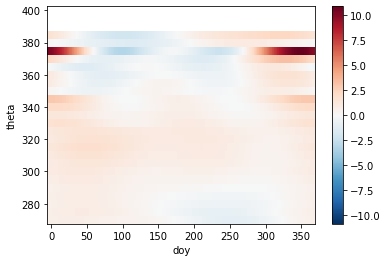

In [8]:
xhat = np.arange(-5, 365+5, 1)    
yhat = xr.DataArray(np.ones((len(dco2.theta), len(xhat)))*np.nan, 
                    dims=('theta', 'doy'),
                    coords=dict(
                        theta=dco2.theta,
                        doy=xhat,
                    ),
                   )

doy = dco2.doy.values
for k in range(len(dco2.theta)):
    x, y = util.antyear_daily(doy, dco2.isel(theta=k).values)
    missing = np.isnan(x) | np.isnan(y)
    if np.sum(~missing) < 5:
        continue
    p, pcov = ec.curve_fit(
        ec.harmonic, 
        xdata=x[~missing]/365.25, 
        ydata=y[~missing], 
    )

    yhat.data[k, :] = ec.harmonic(xhat/365.25, *p)

    
seasonal_amplitude = (yhat.max('doy') - yhat.min('doy'))
yhat.plot()

## Hovmöller visualization

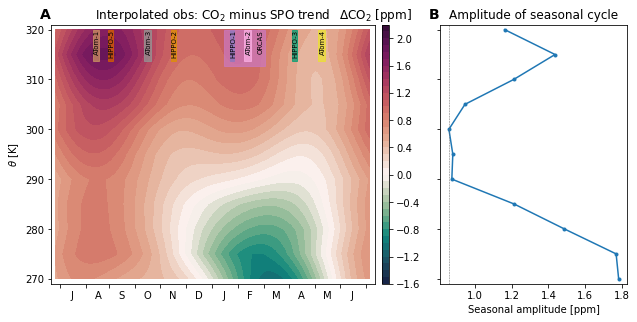

In [9]:
campaign_info = obs_aircraft.get_campaign_info(verbose=False, lump_orcas=True)

fig = plt.figure(figsize=(8, 4)) #dpi=300)

c_spec = figure_panels.marker_spec_campaigns(lump_orcas=True)
txt_box_props = dict(boxstyle='square,pad=0', facecolor='none', edgecolor='none')

# set up plot grid
gs = gridspec.GridSpec(
    nrows=1, ncols=4, 
    width_ratios=[0.65, 0.015, 0.075, 0.375],
    left=0., right=1.,
    bottom=0.05, top=0.95,
    hspace=0.25, wspace=0.05,
)
axs = np.empty((1, 2)).astype(object)
axs[0, 0] = plt.subplot(gs[0, 0])
cax = plt.subplot(gs[0, 1])
axs[0, 1] = plt.subplot(gs[0, 3])

ax = axs[0, 0] 
pc = ax.contourf(
              yhat.doy,
              yhat.theta.sel(theta=slice(None, 320)), 
              yhat.sel(theta=slice(None, 320)),
              levels=figure_panels.levels,
              norm=figure_panels.divnorm,
              cmap=figure_panels.cmap,
             )

for c, info in campaign_info.items():
    tb = util.day_of_year(info['time_bound'])
    x, _ = util.antyear_daily(tb, np.ones(2))
    ax.axvspan(
        x[0], x[1], 
        ymin=0.84 if c == 'ORCAS' else 0.86, 
        ymax=0.98,
        color=c_spec[c]['color'], 
        alpha=1 if c in ['HIPPO-1', 'ATOM-2'] else 0.75, 
    )
    xtxt = x.mean() + np.diff(x)*0.18
    if c == 'ORCAS':
        xtxt += 10
    ax.text(
        xtxt, 320., c,
        rotation=90, 
        ha='center', 
        verticalalignment='top', 
        color='k', 
        fontsize=7,
        bbox=txt_box_props,
    )
    
    
ax.set_ylim((269., 321.))
ax.set_title('Interpolated obs: CO$_2$ minus SPO trend')


cb = plt.colorbar(pc, cax=cax)
cb.ax.set_title('$\Delta$CO$_2$ [ppm]      ', loc='center')

ax.set_ylabel('$\\theta$ [K]')

ax.set_xlim((-10, 375))
ax.set_xticks(figure_panels.bomday)
ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+['']);

ax = axs[0, 1]
ax.plot(
    seasonal_amplitude.sel(theta=slice(None, 320)), 
    yhat.theta.sel(theta=slice(None, 320)), 
    '.-', label='Seasonal amplitude')

ax.set_yticklabels([]);
ax.set_xlabel('Seasonal amplitude [ppm]')
ax.axvline(seasonal_amplitude.sel(theta=300.), lw=0.5, c='dimgray', linestyle='--')
ax.set_ylim((269., 321.))
ax.set_title('Amplitude of seasonal cycle')
util.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.02)

util.savefig('seasonal-amplitude')